In [24]:
import pandas as pd
import geopandas
from toporel import get_average_side_length, apply_default_buffer
import shapely
import geojson
from lat_lon_distance2 import lat_lon_distance, get_bbox_by_dist_radius
import re
geojson.geometry.DEFAULT_PRECISION = 6

In [ ]:
data_dir = 'data/london_pois_bbox.csv' # or 'data/london_pois_5500.csv'

In [7]:
pois = pd.read_csv(data_dir, low_memory=False)
pois['geometry'] = geopandas.GeoSeries.from_wkt(pois['geometry'])
pois['centroid'] = pois['geometry'].apply(lambda g: g.centroid)#geopandas.GeoSeries.from_wkt(pois['centroid'])
print(pois.shape)
pois.head()

(127975, 10)


,osm_id,name,amenity,shop,tourism,landuse,leisure,building,geometry,centroid
0,1095165061,NaN,NaN,NaN,NaN,NaN,NaN,semidetached_house,"POLYGON ((-0.11687 51.47101, -0.11689 51.47102...",POINT (-0.1168135 51.4710815)
1,7089341495,NaN,bench,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-0.16235 51.49976, -0.16245 51.49966...",POINT (-0.162454 51.499764)
2,232592675,NaN,NaN,NaN,NaN,NaN,NaN,residential,"POLYGON ((-0.14357 51.53668, -0.14358 51.53668...",POINT (-0.1435299798229896 51.53672534404523)
3,4832762483,NaN,telephone,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-0.08611 51.48953, -0.08621 51.48942...",POINT (-0.086215 51.48952499999999)
4,5317958,Saatchi Gallery,NaN,NaN,gallery,NaN,NaN,NaN,"POLYGON ((-0.15858 51.49032, -0.15865 51.49031...",POINT (-0.1587503122229398 51.49064974556269)


In [8]:
# Eliminate LineStrings
pois.loc[pois['geometry'].apply(lambda e: e.geom_type) == 'LineString', 'geometry'] = pois.loc[pois['geometry'].apply(lambda e: e.geom_type) == 'LineString', 'geometry'].apply(lambda e: e.centroid)

In [9]:
# Checks for rows without any keyword
pois[((pois.amenity.isna())&(pois.shop.isna())&(pois.tourism.isna())&(pois.landuse.isna())&(pois.leisure.isna())&(pois.building.isna()))].shape

(0, 10)

In [10]:
# Checks for duplicated osm_ids
pois['osm_id'].value_counts().max()

1

In [11]:
# standardize 6 decimal digits for lat long
pois['centroid'] = pois['centroid'].apply(lambda p: shapely.geometry.shape(geojson.geometry.Point(p.coords[0])))
pois['geometry'] = pois['geometry'].apply(lambda g: shapely.geometry.shape(geojson.loads(shapely.to_geojson(g))))

In [12]:
pois['avg_side_length'] = pois['geometry'].apply(get_average_side_length)

In [13]:
# The median value among the average side lengths of the polygons
point_buffer_size = pois.loc[pois['avg_side_length']>0, 'avg_side_length'].median()
point_buffer_size

0.00014142135623714184

In [14]:
pois['geometry'].apply(lambda e: e.area).sum()

0.02533557427300035

In [15]:
pois['geometry_buffer'] = pois['geometry'].apply(lambda e: apply_default_buffer(e, point_buffer_size=point_buffer_size))

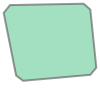

In [17]:
pois['geometry_buffer'].values[0]

In [19]:
pois['geometry'] = pois['geometry_buffer']
pois['geometry'].apply(lambda e: e.area).sum()

0.0331340531642215

In [20]:
# standardize 6 decimal digits for lat long
pois['geometry'] = pois['geometry'].apply(lambda g: shapely.geometry.shape(geojson.loads(shapely.to_geojson(g))))
pois.head()

,osm_id,name,amenity,shop,tourism,landuse,leisure,building,geometry,centroid,avg_side_length,geometry_buffer
0,1095165061,NaN,NaN,NaN,NaN,NaN,NaN,semidetached_house,"POLYGON ((-0.116872 51.470993, -0.116887 51.47...",POINT (-0.116814 51.471081),0.000074,POLYGON ((-0.116871731887777 51.47099275812427...
1,7089341495,NaN,bench,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-0.162444 51.499654, -0.162464 51.49...",POINT (-0.162454 51.499764),0.000141,"POLYGON ((-0.1624440000000002 51.499654, -0.16..."
2,232592675,NaN,NaN,NaN,NaN,NaN,NaN,residential,"POLYGON ((-0.143564 51.536666, -0.143576 51.53...",POINT (-0.14353 51.536725),0.000053,POLYGON ((-0.1435643215509006 51.5366664360323...
3,4832762483,NaN,telephone,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-0.086205 51.489415, -0.086225 51.48...",POINT (-0.086215 51.489525),0.000141,POLYGON ((-0.0862049999999998 51.4894149999999...
4,5317958,Saatchi Gallery,NaN,NaN,gallery,NaN,NaN,NaN,"POLYGON ((-0.158606 51.490278, -0.158686 51.49...",POINT (-0.15875 51.49065),0.000304,POLYGON ((-0.1586062202734564 51.4902783975701...


In [21]:
pois['centroid'] = pois['geometry'].apply(lambda g: g.centroid)

In [22]:
# standardize 6 decimal digits for lat long
pois['centroid'] = pois['centroid'].apply(lambda p: shapely.geometry.shape(geojson.geometry.Point(p.coords[0])))


In [23]:
pois.drop('avg_side_length', axis=1, inplace=True)

In [25]:
def simplify_string(string):
    return re.sub(r"[ ]+", "_"  ,re.sub(r"[^a-zA-Z_]", " ", string).strip())

In [26]:
pois.fillna('', inplace = True)

In [27]:
pois['amenity'] = pois['amenity'].apply(simplify_string)
pois['shop'] = pois['shop'].apply(simplify_string)
pois['tourism'] = pois['tourism'].apply(simplify_string)
pois['landuse'] = pois['landuse'].apply(simplify_string)
pois['leisure'] = pois['leisure'].apply(simplify_string)
pois['building'] = pois['building'].apply(simplify_string)

In [ ]:
override_file = False
if override_file is True:
    pois.to_csv(data_dir, index = False)
else:
    pois.to_csv(f'{data_dir}_buffered.csv', index=False)

In [29]:
center = (-0.118092, 51.509865)
dist = 12000/2
get_bbox_by_dist_radius(center, dist)

(-0.20479033521186382,
 51.45590570364487,
 -0.03139366479178516,
 51.56382429635512)

In [30]:
center = (-0.118092, 51.509865)
dist = 5500/2
get_bbox_by_dist_radius(center, dist)

(-0.15782873513750623,
 51.48513365583724,
 -0.07835526486445585,
 51.534596344162765)